In [ ]:
!pip install

In [123]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tslearn.piecewise import PiecewiseAggregateApproximation
from sklearn.model_selection import train_test_split
from tslearn.preprocessing import TimeSeriesScalerMinMax
import sys
sys.path.append('../')
import default_style

font sizes set


In [2]:
TS_DATASET_FOLDER = os.path.join('..', 'dataset')
TS_PREPROC_FOLDER = os.path.join(TS_DATASET_FOLDER, 'preprocessed_traces')
DF_PREPROC_FILE = os.path.join(TS_PREPROC_FOLDER, 'preproc_ts.df')

TARGET = 'statement'
TRACES = 'syllables_02_sc'

NB: good accuracy for:
- vocal_channel--std_phon_trace l=0.15
- sex--spectral_centroid l=0.15( ~0.98 accuracy if separate by vocal_channel)
- sex--syllables_02_sc l=0.25(~0.8 accuracy even without division)
- statement--syllables_02_sc l=0.60-0.90(~0.83 accuracy even without division)

In [3]:
df = pd.read_csv(DF_PREPROC_FILE).drop(columns=['Unnamed: 0'])
df.head()

,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,path,sex,begin_s,end_s,fourier_coeffs,filtered_fourier_coeffs,syll_0_start_index,syll_1_start_index,syll_2_start_index,syll_3_start_index,syll_4_start_index,syll_5_start_index,syll_6_start_index,syll_7_start_index
0,speech,neutral,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.009833,2.252000,[1.9371510e-07 1.2311488e-02 1.1168750e-02 ......,[1.9371510e-07 1.2311473e-02 1.1168692e-02 ......,0,1128,2240,3200,4304,5208,5808,7448
1,speech,neutral,normal,kids,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.068500,2.294667,[3.5017729e-07 2.6199006e-02 2.5683409e-02 ......,[3.5017729e-07 2.6198970e-02 2.5683273e-02 ......,0,2008,3208,3880,4224,5112,5800,7352
2,speech,neutral,normal,dogs,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.012000,2.238500,[2.4959445e-07 1.2348385e-02 1.0678725e-02 ......,[2.49594450e-07 1.23483688e-02 1.06786685e-02 ...,0,2816,3352,3912,4296,5232,5880,7352
3,speech,neutral,normal,dogs,2nd,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.008833,2.187167,[1.1920929e-07 1.2154797e-02 1.6620804e-02 ......,[1.1920929e-07 1.2154780e-02 1.6620707e-02 ......,0,1664,2664,3208,3672,4840,5448,7064
4,speech,calm,normal,kids,1st,actor_01,../dataset/Audio_Speech_Actors_01-24/Actor_01/...,M,1.023667,2.534167,[1.1920929e-07 2.0026919e-03 7.9689088e-04 ......,[1.1920929e-07 2.0026902e-03 7.9688808e-04 ......,0,2088,3584,4832,5800,6944,7560,9056


In [4]:
traces_dict = {}
files = os.listdir(TS_PREPROC_FOLDER)

for file in files:

    if file.endswith('.npy'):
        file_path = os.path.join(TS_PREPROC_FOLDER, file)
        # dictionary keys are the file names
        key = os.path.splitext(file)[0]
        # load array
        traces_dict[key] = np.load(file_path, allow_pickle=True)

traces_dict.keys()

dict_keys(['clean_trace', 'predictions', 'spectral_centroid', 'std_phon_trace', 'syllables_02_sc', 'syllables_02_STFT', 'syllables_0_ts', 'syllables_1_ts', 'syllables_2_ts', 'syllables_3_ts', 'syllables_4_ts', 'syllables_5_ts', 'syllables_6_ts', 'syllables_fourier', 'traces_fourier'])

In [5]:
traces = traces_dict[TRACES]
traces.shape
# traces = traces.reshape((traces.shape[0], traces.shape[1]*traces.shape[2]))
# traces.shape

(2452, 27)

### Separate song/speech to improve sex classification or skip next

In [302]:
"""traces_s = []
for i in range(len(traces)):
    if df['vocal_channel'][i]=='song':
        traces_s.append(i) 
len(traces_s)

traces = traces[traces_s]

df = df[df['vocal_channel']=='song']

df = df.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(np.stack(traces), df[TARGET], 
test_size=0.2, random_state=100)"""

"traces_s = []\nfor i in range(len(traces)):\n    if df['vocal_channel'][i]=='song':\n        traces_s.append(i) \nlen(traces_s)\n\ntraces = traces[traces_s]\n\ndf = df[df['vocal_channel']=='song']\n\ndf = df.reset_index(drop=True)\n\nX_train, X_test, y_train, y_test = train_test_split(np.stack(traces), df[TARGET], \ntest_size=0.2, random_state=100)"

## Traces splitting

In [6]:
# sort by actors
sorted_indices = df['actor'].argsort()
df = df.iloc[sorted_indices].reset_index(drop=True)

traces = traces[sorted_indices]

traces

array([[419.08209844, 349.35723506, 544.33671361, ..., 277.51863749,
        378.26512716, 253.68883891],
       [301.47501002, 339.00811566, 357.11550568, ..., 262.35697447,
        330.05274818, 335.25545327],
       [336.40745837, 454.8437495 , 430.46974817, ..., 270.59756814,
        274.52819802, 260.62863826],
       ...,
       [382.78172495, 365.39762173, 338.32377007, ..., 510.74495241,
        662.94740862, 606.81773152],
       [347.2473202 , 400.3565358 , 436.45702937, ..., 263.79908923,
        226.97672064, 239.85378015],
       [412.48677416, 404.33498908, 484.31908603, ..., 392.29461001,
        379.51697576, 391.18628789]])

In [7]:
from sklearn.model_selection import train_test_split

split_index = df[df['actor'] == 'actor_19'].index[0]

X_train = traces[:split_index]
X_test = traces[split_index:]

y_train = df[TARGET][:split_index].to_numpy()
y_test = df[TARGET][split_index:].to_numpy()

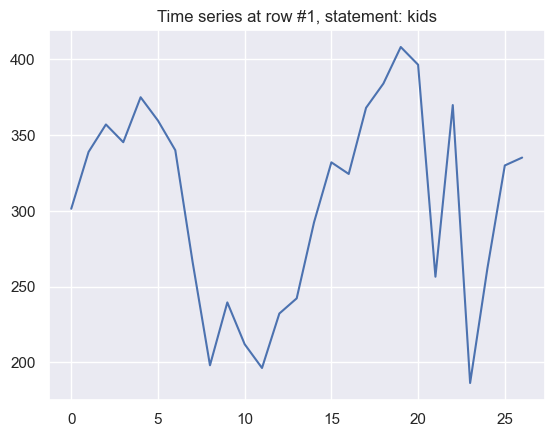

In [8]:
index = 1
statement = df[TARGET][index]
plt.plot(X_train[index])
plt.title(f'Time series at row #{index}, statement: {statement}')
plt.show()

In [9]:
np.any(np.isinf(traces))

False

# Shapelets

In [111]:
from tslearn.shapelets import ShapeletModel, grabocka_params_to_shapelet_size_dict,  LearningShapelets

n_ts, ts_size = X_train.shape
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts, ts_sz=ts_size,
                                                       n_classes=2, l=0.4, r=1)
print('n_ts', n_ts)
print('ts_sz', ts_size)
print('shapelet_sizes', shapelet_sizes)

n_ts 1828
ts_sz 27
shapelet_sizes {10: 4}


In [112]:
import tensorflow as tf
from tensorflow import keras
optimizer = tf.keras.optimizers.SGD()

In [113]:
# -------- Shapelets extraction --------

# shapelets extraction model
shapelet_model =  ShapeletModel(optimizer=optimizer, random_state=42,n_shapelets_per_size=shapelet_sizes, batch_size=16, max_iter=100)
shapelet_model.fit(X_train, y_train)

# shapelets extraction
shapelets = shapelet_model.shapelets_
shapelets

C:\Users\emanu\.virtualenvs\DM2-HUE9YkAX\Lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


array([array([[373.90637207],
              [382.52740479],
              [354.18878174],
              [334.58401489],
              [303.90353394],
              [290.43093872],
              [276.17977905],
              [281.96658325],
              [366.46078491],
              [542.89624023]]), array([[534.98046875],
                                       [500.77258301],
                                       [409.49716187],
                                       [332.65332031],
                                       [292.02957153],
                                       [280.31750488],
                                       [280.8137207 ],
                                       [318.30541992],
                                       [326.31518555],
                                       [345.46365356]]),
       array([[297.80456543],
              [299.52001953],
              [304.0645752 ],
              [307.42892456],
              [327.97195435],
              [391.99075317]

## Visualize Shapelets

In [114]:
c=list(shapelet_sizes.values())
distances = shapelet_model.transform(X_train)
predicted_locations = shapelet_model.locate(X_train)

In [115]:
distances = np.stack(distances, axis=-1)

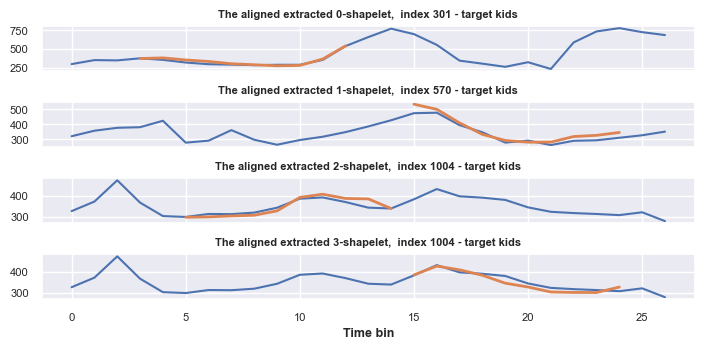

In [126]:
# Plot the shapelet and align it on the best matched time series. 
f, ax = plt.subplots(c[0], 1, sharex=True, figsize=default_style.FULLSIZE_FIGURE)
for n_shap in range(c[0]):    
    test_ts_id = np.argmin(distances[n_shap])
    shap = shapelet_model.shapelets_[n_shap]
    pos = predicted_locations[test_ts_id, n_shap]
    statement = df[TARGET][test_ts_id]
    ax[n_shap].plot(X_train[test_ts_id].ravel())
    ax[n_shap].plot(np.arange(pos, pos + len(shap)), shap, linewidth=2)
    # ax[0].axvline(pos, color='k', linestyle='--', alpha=0.25)
    ax[n_shap].set_title(f"The aligned extracted {n_shap}-shapelet,  index {test_ts_id} - target {statement}")
#     ax[n_shap].set_ylabel("[Hz]");
ax[n_shap].set_xlabel("Time bin")
f.tight_layout(pad=1.0)
f.savefig("../images/shapelet_found.pdf")
plt.show()

## KNN classifier

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

"""param_grid = {
    'max_depth': np.arange(2, 50),
    'max_features': ['auto', 'sqrt', 'log'],
    'criterion': ["gini","entropy", "log_loss"],
}

grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)

grid.fit(X_train_transformed, y_train)
print(grid.best_params_, grid.best_score_)

dec = grid.best_estimator_
y_pred = dec.predict(X_test_transformed)

from sklearn.metrics import accuracy_score, f1_score, classification_report

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))"""

'param_grid = {\n    \'max_depth\': np.arange(2, 50),\n    \'max_features\': [\'auto\', \'sqrt\', \'log\'],\n    \'criterion\': ["gini","entropy", "log_loss"],\n}\n\ngrid = GridSearchCV(\n    DecisionTreeClassifier(),\n    param_grid=param_grid,\n    cv=RepeatedStratifiedKFold(random_state=0),\n    n_jobs=-1,\n    refit=True,\n)\n\ngrid.fit(X_train_transformed, y_train)\nprint(grid.best_params_, grid.best_score_)\n\ndec = grid.best_estimator_\ny_pred = dec.predict(X_test_transformed)\n\nfrom sklearn.metrics import accuracy_score, f1_score, classification_report\n\nprint(\'Accuracy %s\' % accuracy_score(y_test, y_pred))\nprint(\'F1-score %s\' % f1_score(y_test, y_pred, average=None))\nprint(classification_report(y_test, y_pred))'

In [117]:
# -------- Shapelets distances computation --------

X_train_transformed = shapelet_model.transform(X_train)
X_test_transformed = shapelet_model.transform(X_test)

In [118]:
# -------- Hyperparameters tuning --------

param_grid = {
    'n_neighbors': np.arange(2, 50),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'minkowski'],
}

grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=param_grid,
    cv=RepeatedStratifiedKFold(random_state=0),
    n_jobs=-1,
    refit=True,
)

grid.fit(X_train_transformed, y_train)
print(grid.best_params_, grid.best_score_)

{'metric': 'euclidean', 'n_neighbors': 44, 'weights': 'uniform'} 0.7212812336252713


In [119]:
# -------- Classification --------

knn = grid.best_estimator_
y_pred = knn.predict(X_test_transformed)

In [120]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.717948717948718
F1-score [0.73731343 0.69550173]
              precision    recall  f1-score   support

        dogs       0.69      0.79      0.74       312
        kids       0.76      0.64      0.70       312

    accuracy                           0.72       624
   macro avg       0.72      0.72      0.72       624
weighted avg       0.72      0.72      0.72       624

